In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-groq langchain-community
#%pip langchain-anthropic
#%pip langchain-openai

In [2]:
import getpass
import os
from pprint import pprint
from getpass import getpass

In [3]:
os.environ['GROQ_API_KEY'] = getpass("GROQ_API_KEY")

GROQ_API_KEY··········


## Build a Basic Chatbot

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it",
               temperature=0,
               max_tokens=256,
               max_retries=2)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

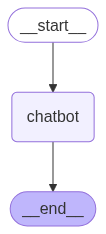

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
response = graph.invoke({"messages": [{"role": "user", "content": "What is agentic ai?"}]})

In [9]:
response['messages'][-1].content

"Agentic AI refers to a type of artificial intelligence that is designed to be **autonomous and goal-oriented**. \n\nHere's a breakdown:\n\n**Autonomous:** Agentic AI systems can operate independently, making decisions and taking actions without constant human intervention. They have the ability to perceive their environment, interpret information, and plan and execute actions to achieve their goals.\n\n**Goal-Oriented:** Agentic AI is driven by specific objectives. These goals can be pre-defined by humans or learned through interaction with the environment. The AI system will strive to achieve these goals through its actions.\n\n**Key Characteristics of Agentic AI:**\n\n* **Goal Recognition:** The ability to identify and understand the desired outcomes.\n* **Planning:** Developing a sequence of actions to achieve the goals.\n* **Action Execution:** Carrying out the planned actions in the real or simulated world.\n* **Learning and Adaptation:**  The capacity to learn from experiences a

In [10]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        response = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: what is agentic ai
Assistant: Agentic AI refers to a type of artificial intelligence that possesses the ability to act autonomously and make decisions in pursuit of specific goals. 

Here's a breakdown of key characteristics:

**Key Features:**

* **Goal-Oriented:** Agentic AI systems are designed with clear objectives and work towards achieving them.
* **Autonomous:** They can operate independently without constant human intervention.
* **Reactive:** They can perceive their environment and respond to changes accordingly.
* **Proactive:** They can anticipate future events and take actions to influence them.
* **Learning and Adaptable:** Many agentic AI systems incorporate machine learning algorithms, allowing them to learn from experience and improve their performance over time.

**Examples:**

* **Self-Driving Cars:** Navigate roads, make decisions about speed and lane changes, and avoid obstacles.
* **Robotics:** Perform tasks in manufacturing, healthcare, or exploration, adapt

## Adding Tools

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

In [12]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_tool_builder = StateGraph(State)

from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it",
               temperature=0,
               max_tokens=256,
               max_retries=2)

In [13]:
os.environ['TAVILY_API_KEY'] = getpass("TAVILY_API_KEY")

TAVILY_API_KEY··········


In [14]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

/tmp/ipython-input-14-4137703420.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


In [15]:
llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [16]:
graph_tool_builder.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_tool_builder.add_node("tools", tool_node)

graph_tool_builder.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_tool_builder.add_edge("tools", "chatbotWithTools")
graph_tool_builder.set_entry_point("chatbotWithTools")
tool_graph = graph_tool_builder.compile()

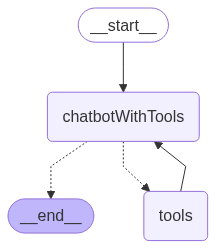

In [17]:
from IPython.display import Image, display

try:
    display(Image(tool_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

#        print("User: " + user_input)
        response = tool_graph.invoke({"messages": [{"role": "user", "content": user_input}]})
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: what is agentic ai
Assistant: Agentic AI has applications in software development, customer support, cybersecurity, and business intelligence. 
It can also be used in healthcare for tasks such as robotic surgery assistance, streamlining workflows, and providing predictive, customizable care. 



User: who won 2025 ipl final
Assistant: Rajasthan Royals won the 2025 IPL final. 

User: can you check again
Assistant: <tool-use>{"tool_call":{"id":"y
```json
{"tool_call":{"id":"pending","type":"function","function":{"name":"tavily_search_results_json"
```

User: quit
Goodbye!


## Adding Memory to Graph

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [20]:
graph_tool_builder = StateGraph(State)

graph_tool_builder.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_tool_builder.add_node("tools", tool_node)

graph_tool_builder.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_tool_builder.add_edge("tools", "chatbotWithTools")
graph_tool_builder.set_entry_point("chatbotWithTools")
tool_graph = graph_tool_builder.compile(checkpointer=memory)

In [21]:
config = {"configurable": {"thread_id": "1"}}

In [22]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

#        print("User: " + user_input)
        response = tool_graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: who won ipl in 2025
Assistant: Royal Challengers Bengaluru 

User: who was man of the match
Assistant: Krunal Pandya 

User: quit
Goodbye!
